In [76]:
import os
import pathlib
# import glob
import random
import shutil

from PIL import Image

import torch
from torch import nn

import torchvision
from torchvision import transforms

# Note: this notebook requires torch >= 1.10.0
torch.__version__

'2.0.1'

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Data Preparation

1. Make training, validation and testing folder
1. Move 70% of the data to training folder
1. Move 20% of the data to validation folder
1. Move 10% of the data to testing folder

Folder structure after this process

```
data
    └─── EuroSAT_MS
        ├─── train
        |   └─── AnnualCrop
        |   |   ├─── AnnualCrop_1.tif
        |   |   ├─── AnnualCrop_2.tif
        |   |   └─── ...
        |   ├─── Forest
        |   |   ├─── Forest_1.tif
        |   |   ├─── Forest_2.tif
        |   |   └─── ...
        ├─── valid
        |   └─── AnnualCrop
        |   |   ├─── AnnualCrop_3.tif
        |   |   ├─── AnnualCrop_4.tif
        |   |   └─── ...
        |   ├─── Forest
        |   |   ├─── Forest_3.tif
        |   |   ├─── Forest_4.tif
        |   |   └─── ...
        └─── test
            └─── AnnualCrop
            |   ├─── AnnualCrop_1.tif
            |   ├─── AnnualCrop_2.tif
            |   └─── ...
            └─── Forest
                ├─── Forest_1.tif
                ├─── Forest_2.tif
                └─── ...
```

In [32]:
RANDOM_SEED = 42

In [100]:
# Prepare the folder and its name
root_dir = os.getcwd()
root_dir = pathlib.Path(root_dir)

data_path = root_dir / "data"
eurosat_path = data_path / "EuroSAT"

# Setup train, valid, and testing paths
train_path = eurosat_path / "train"
valid_path = eurosat_path / "valid"
test_path = eurosat_path / "test"

# put all the class names inside a list, 
# the last 3 is test, train, and valid, exclude these
class_name = os.listdir(eurosat_path)#[:-3]

In [102]:
# make the train, test, and valid folders
for data_folder in [train_path, valid_path, test_path]:
    if not os.path.exists(data_folder):
        os.makedirs(data_folder, exist_ok=False)
        for class_folder in class_name:
            os.makedirs(pathlib.Path(data_folder / class_folder))
    else:
        print(f"{data_folder} already exist, skipping the process...")

d:\0_amri_local\99_personal\ztm_pytorch\data\EuroSAT\train already exist, skipping the process...
d:\0_amri_local\99_personal\ztm_pytorch\data\EuroSAT\valid already exist, skipping the process...
d:\0_amri_local\99_personal\ztm_pytorch\data\EuroSAT\test already exist, skipping the process...


In [103]:
class_folder

'SeaLake'

In [104]:
temp_class_folder = pathlib.Path(eurosat_path / class_folder)

random.seed(RANDOM_SEED)
temp_img_list = os.listdir(temp_class_folder)
total_img = int(len(temp_img_list))

train_img_list = random.sample(temp_img_list, int(total_img*.7))
temp_img_list = list(set(temp_img_list) - set(train_img_list))
valid_img_list = random.sample(temp_img_list, int(total_img*.2))
test_img_list = list(set(temp_img_list) - set(valid_img_list))

print(f"total number of images: {total_img}")
print(f"number of images in train: {len(train_img_list)}")
print(f"number of images in valid: {len(valid_img_list)}")
print(f"number of images in test: {len(test_img_list)}")

total number of images: 3000
number of images in train: 2100
number of images in valid: 600
number of images in test: 300


In [91]:
for _ in test_img_list[:5]:
    # print(os.path.exists(pathlib.Path(eurosat_path / "SeaLake" / _)))
    source = pathlib.Path(eurosat_path / "SeaLake" / _)
    destination = pathlib.Path(eurosat_path / "test" / "SeaLake" / _)
    shutil.copyfile(source, destination)

In [92]:
source

WindowsPath('d:/0_amri_local/99_personal/ztm_pytorch/data/EuroSAT/2750/SeaLake/SeaLake_427.jpg')

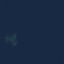

In [93]:
Image.open(source)

In [30]:
# # Define the transformation for the dataset
# transform = transforms.Compose([
#     # transforms.Resize((32, 32)),  # Resize images to 32x32 pixels
#     transforms.ToTensor(),  # Convert images to tensors
# ])



# train_data = datasets.ImageFolder(root=train_dir, # target folder of images
#                                   transform=transform, # transforms to perform on data (images)
#                                   target_transform=None) # transforms to perform on labels (if necessary)


# # Create a data loader for the dataset
# train_loader = torch.utils.data.DataLoader(
#     train_dataset,
#     batch_size=64,
#     shuffle=True
# )
